###########################################################################
# AAI 511 - Group 8
## MIDI Dataset
Christopher Teli, Ikenna Opurum, Adam Graves
###########################################################################

###Tasks Breakdown
* Data Collection: Data is collected and provided to you.
* Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.
* Feature Extraction: Extractfeatures from the MIDI files, such as notes, chords, and tempo, using music analysis tools.
* Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.
* Model Training: Train the deep learning model using the pre-processed and feature-extracted data.
* Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.
* Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.





In [1]:
#Install library for loading a MIDI file
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 4.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=ee19dbbdc35ba65c7242d0f2c07b6bde760dbc71eba7a795209d0c52db505e6b
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title 1: Functions for Data Collection
# Function for Feature extractions
import os
import glob
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from keras import models, layers

# Check if pickle file exists and use the file for dataset
import pickle

In [3]:
#@title 2: Do Data Extraction (ETL) process
# Directory of MIDI files
base_dir = '/content/drive/MyDrive/AAI-511/Load Data/Final'

# Specify the path and filename of the pickle file
# Since the pkl file exists, that means the data was processed and features extracted
pickle_file_name = 'team8_composer_dataset.pkl'

In [4]:
#@title 2.1: Extract features using librosa for further feature extraction
def calculate_features(midi_file):
    # Load MIDI file
    midi_data = pretty_midi.PrettyMIDI(midi_file)

    # Time interval for calculating features
    interval = 1.0  # 1 second
    times = np.arange(0, midi_data.get_end_time(), interval)

    # Create arrays for storing time series data
    pitch = np.zeros(len(times))
    volume = np.zeros(len(times))
    note_density = np.zeros(len(times))
    tempo = np.zeros(len(times))

    # Calculate time series data for each feature
    for i, t in enumerate(times):
        # Get notes that are playing at this time
        notes = [note for note in midi_data.instruments[0].notes if note.start <= t < note.end]

        # Calculate average pitch
        if notes:
            pitch[i] = np.mean([note.pitch for note in notes])

        # Calculate note density (notes per second)
        note_density[i] = len(notes) / interval

        # Calculate average volume
        if notes:
            volume[i] = np.mean([note.velocity for note in notes])

    # Calculate rhythmic complexity (variance in inter-onset intervals)
    inter_onset_intervals = np.diff([note.start for note in midi_data.instruments[0].notes])
    rhythmic_complexity = np.var(inter_onset_intervals)

    # Calculate tempo for each moment in time
    tempo_changes = midi_data.get_tempo_changes()
    tempo = np.interp(times, tempo_changes[0], tempo_changes[1])

    return times, pitch, note_density, volume, rhythmic_complexity, tempo

In [5]:
#@title 2.2: Process composer data to df
def process_composer_data():
    # Initialize DataFrame
    df = pd.DataFrame(columns=["Composer","Times", "Pitch", "Note_Density", "Volume",
                               "Rhythmic_Complexity", "Tempo"])

    # Iterate over all composer directories
    for composer_dir in glob.glob(os.path.join(base_dir, '*')):
        # Get the composer's name
        composer_name = os.path.basename(composer_dir)
        print(f"Processing {composer_name} MIDI files...")

        # Iterate over all MIDI files in composer's directory
        for midi_file in glob.glob(os.path.join(composer_dir, '*.mid')):
            print(f"Processing {midi_file}...")
            try:
                times, pitch, note_density, volume, rhythmic_complexity, tempo = calculate_features(midi_file)
                # Append to DataFrame
                df = df.append({"Composer": composer_name, "Times": times, "Pitch": pitch,
                                "Note_Density": note_density, "Volume": volume,
                                "Rhythmic_Complexity": rhythmic_complexity,
                                "Tempo": tempo},
                               ignore_index=True)
            except Exception as e:
                print(f"Error processing {midi_file}: {str(e)}")

    # Write the DataFrame to a pickle file
    df.to_pickle(base_dir + "/" + pickle_file_name)

    return df

In [8]:
#@title 2.3: Data Processing - Feature extraction

pickle_file = base_dir + "/" + pickle_file_name
# Check if the pickle file exists
if not os.path.exists(pickle_file):
    print("Music Data not Pickled, creating dataset using feature extract.")
    df = process_composer_data()
else:
    # Open the pickle file in binary mode and load the data
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)

    # Create a DataFrame from the loaded data
    df = pd.DataFrame(data)

    # Now you have your DataFrame ready for use
    print(df.head())

  Composer                                              Times  \
0     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
1     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
2     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
3     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
4     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   

                                               Pitch  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.0,...   
1  [0.0, 78.0, 78.0, 0.0, 66.0, 66.0, 0.0, 0.0, 6...   
2  [0.0, 67.0, 43.0, 0.0, 67.0, 0.0, 43.0, 55.0, ...   
3  [0.0, 0.0, 50.0, 74.0, 0.0, 74.0, 0.0, 74.0, 0...   
4  [0.0, 63.0, 69.0, 0.0, 0.0, 69.0, 0.0, 45.0, 0...   

                                        Note_Density  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
1  [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...   
2  [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...   
3  [0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0,

In [9]:
#@title 2.4: Data Pre-processing - verifications
print(df.head())
print(df.info())

  Composer                                              Times  \
0     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
1     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
2     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
3     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
4     bach  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   

                                               Pitch  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.0,...   
1  [0.0, 78.0, 78.0, 0.0, 66.0, 66.0, 0.0, 0.0, 6...   
2  [0.0, 67.0, 43.0, 0.0, 67.0, 0.0, 43.0, 55.0, ...   
3  [0.0, 0.0, 50.0, 74.0, 0.0, 74.0, 0.0, 74.0, 0...   
4  [0.0, 63.0, 69.0, 0.0, 0.0, 69.0, 0.0, 45.0, 0...   

                                        Note_Density  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
1  [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...   
2  [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...   
3  [0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0,

In [10]:
#@title 2.5: Check df
df.head()

,Composer,Times,Pitch,Note_Density,Volume,Rhythmic_Complexity,Tempo
0,bach,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 127.0...",4.609656,"[120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120..."
1,bach,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 78.0, 78.0, 0.0, 66.0, 66.0, 0.0, 0.0, 6...","[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[0.0, 127.0, 127.0, 0.0, 127.0, 127.0, 0.0, 0....",1.625026,"[120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120..."
2,bach,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 67.0, 43.0, 0.0, 67.0, 0.0, 43.0, 55.0, ...","[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...","[0.0, 127.0, 127.0, 0.0, 127.0, 0.0, 127.0, 12...",2.137464,"[120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120..."
3,bach,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 50.0, 74.0, 0.0, 74.0, 0.0, 74.0, 0...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 127.0, 127.0, 0.0, 127.0, 0.0, 127....",1.291966,"[120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120..."
4,bach,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 63.0, 69.0, 0.0, 0.0, 69.0, 0.0, 45.0, 0...","[0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[0.0, 127.0, 127.0, 0.0, 0.0, 127.0, 0.0, 127....",0.866606,"[120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120..."


In [11]:
#@title 2.6: Check composer names and Count the occurrences of each 'quality' value
composer_counts = df['Composer'].value_counts()

# Sort the count by 'quality' values
sorted_composer_counts = composer_counts.sort_index()

# Print the count for each 'quality' value
print(sorted_composer_counts)

bach           42
bartok         41
byrd           42
chopin         41
handel         41
hummel         42
mendelssohn    41
mozart         41
schumann       38
Name: Composer, dtype: int64


In [12]:
#@title 2.7: Check on df shape and info
print(df.shape)
print(df.describe())

(369, 7)
       Rhythmic_Complexity
count           369.000000
mean              4.887834
std              27.596210
min               0.000153
25%               0.111875
50%               0.529536
75%               1.486953
max             356.946073


In [13]:
#@title 3: Preparing the data for LSTM
#Load related libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

# Convert all other features to have an extra dimension for LSTM
def transform_series(series, num_steps):
    # Reshape series to (samples, time_steps, features)
    X = np.zeros((len(series), num_steps, 1))
    for i in range(len(series)):
        X[i,:,0] = series.iloc[i][:num_steps]
    return X

In [14]:
#@title 3.1: Split train and test data sets (80-20)
# Using stratify to ensure the datasets have same prorportions of each composer as original dataset
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Composer'])

# Second, we separate the remaining data into the train and validation sets (75-25)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=42, stratify=df_train_val['Composer'])

# The train/val/test split is now 60%/20%/20%

# Encode the labels
encoder = LabelEncoder()
encoder.fit(df['Composer'])  # Fit on the whole dataset

# Transform the labels to one-hot encoded form for each subset
y_train = np_utils.to_categorical(encoder.transform(df_train['Composer']))
y_val = np_utils.to_categorical(encoder.transform(df_val['Composer']))
y_test = np_utils.to_categorical(encoder.transform(df_test['Composer']))

In [15]:
#@title 3.2: Apply transform_series on each feature for each subset
def prepare_data(df, num_steps):
    pitch = transform_series(df['Pitch'], num_steps)
    note_density = transform_series(df['Note_Density'], num_steps)
    volume = transform_series(df['Volume'], num_steps)
    rhythmic_complexity = np.array([df['Rhythmic_Complexity'].values]*num_steps).T[:,:,np.newaxis]
    tempo = transform_series(df['Tempo'], num_steps)

    X = np.concatenate([pitch, note_density, volume, rhythmic_complexity, tempo], axis=-1)
    return X

num_steps = 27
X_train = prepare_data(df_train, num_steps)
X_val = prepare_data(df_val, num_steps)
X_test = prepare_data(df_test, num_steps)

In [16]:
#@title 3.3: Validate shapes
print(y_train.shape[1])
print(X_val.shape)
print(y_train)

9
(74, 27, 5)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
#@title 3.4: X_Train shape validation
X_train.shape

(221, 27, 5)

Notes: X_train contains 221 samples, 27 time_steps and 5 features

In [18]:
#@title 3.5v: Reshape the input data to make it 2D
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

In [19]:
#@title 3.6v: Scale the data using StandardScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

#Build an LSTM Model (Ver.1)

In [59]:
#@title 4v: LSTM Model Building V1 (One Layer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

num_classes = y_train.shape[1]
num_features = 5
model = Sequential([
    LSTM(50, activation='relu', input_shape=(num_steps, num_features)),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 50)                11200     
                                                                 
 dense_5 (Dense)             (None, 9)                 459       
                                                                 
Total params: 11,659
Trainable params: 11,659
Non-trainable params: 0
_________________________________________________________________


In [60]:
#@title 4.1: LSTM V1 Model Training

# LSTM Model Training
history1 = model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], num_steps, num_features),
                    y_train, epochs=10, validation_data=(X_val_scaled.reshape(X_val_scaled.shape[0], num_steps, num_features), y_val))

Epoch 1/10
7/7 [==============================] - 3s 95ms/step - loss: 2.2045 - accuracy: 0.0860 - val_loss: 2.1910 - val_accuracy: 0.1622
Epoch 2/10
7/7 [==============================] - 0s 34ms/step - loss: 2.1522 - accuracy: 0.1810 - val_loss: 2.1939 - val_accuracy: 0.2432
Epoch 3/10
7/7 [==============================] - 0s 30ms/step - loss: 2.0988 - accuracy: 0.2760 - val_loss: 2.1662 - val_accuracy: 0.2432
Epoch 4/10
7/7 [==============================] - 0s 29ms/step - loss: 2.0389 - accuracy: 0.3167 - val_loss: 2.1288 - val_accuracy: 0.2432
Epoch 5/10
7/7 [==============================] - 0s 28ms/step - loss: 1.9336 - accuracy: 0.3439 - val_loss: 2.1981 - val_accuracy: 0.2432
Epoch 6/10
7/7 [==============================] - 0s 25ms/step - loss: 1.8283 - accuracy: 0.3439 - val_loss: 2.4243 - val_accuracy: 0.2973
Epoch 7/10
7/7 [==============================] - 0s 27ms/step - loss: 1.8248 - accuracy: 0.3846 - val_loss: 2.2199 - val_accuracy: 0.2973
Epoch 8/10
7/7 [===========

In [61]:
#@title 4.1v: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled.reshape(X_test_scaled.shape[0], num_steps, num_features), y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

3/3 [==============================] - 0s 9ms/step - loss: 1.8028 - accuracy: 0.4189
Test Loss: 1.8027530908584595
Test Accuracy: 0.4189189076423645


In [62]:
#@title 5: Plot the training and validation loss V1
def plot_learning_curves(history):
    plt.plot(history1.history['loss'], label='Train Loss')
    plt.plot(history1.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.plot(history1.history['accuracy'], label='Train Accuracy')
    plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.show()
    return plot_learning_curves

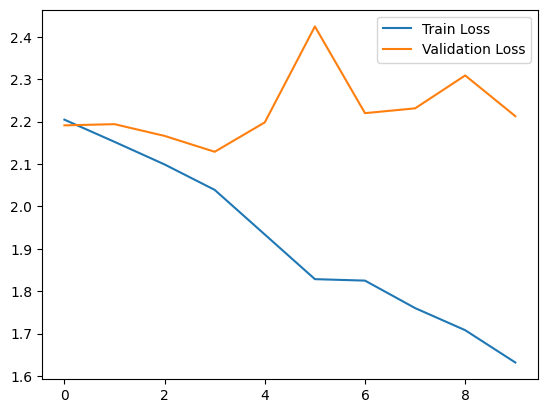

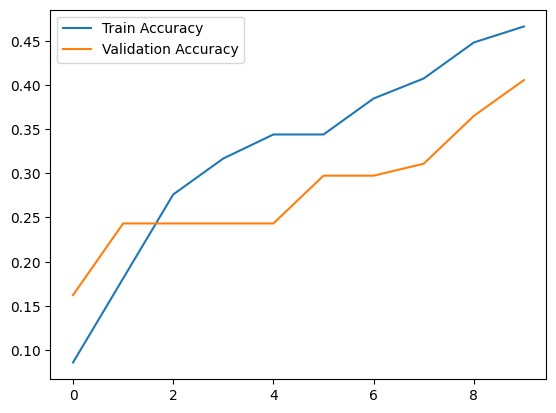

<function __main__.plot_learning_curves(history)>

In [63]:
#@title 5.1: Show plot
plot_learning_curves(history)

Notes: The LSTM Ver 1 model's training and test losses are good at Test Loss: 3.615931272506714
Test Accuracy: 0.4189189076423645w. Next step is to improve the model's performance by adding more layers and increasing the number of epochs.

In [64]:
#@title 6: Make predictions on the scaled and reshaped test set V1
y_test_pred = model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], num_steps, num_features))

# Convert predicted probabilities to class labels
y_test_pred_class = np.argmax(y_test_pred, axis=1)

3/3 [==============================] - 0s 9ms/step


In [65]:
#@title 6.1v: Print the true class labels and predicted class labels
for true_label, pred_label in zip(y_test, y_test_pred_class):
    true_class = encoder.inverse_transform([np.argmax(true_label)])[0]
    pred_class = encoder.inverse_transform([pred_label])[0]
    print(f"True Class: {true_class}, Predicted Class: {pred_class}")

True Class: bach, Predicted Class: mozart
True Class: mozart, Predicted Class: handel
True Class: chopin, Predicted Class: schumann
True Class: hummel, Predicted Class: bach
True Class: hummel, Predicted Class: byrd
True Class: handel, Predicted Class: mozart
True Class: handel, Predicted Class: handel
True Class: mendelssohn, Predicted Class: hummel
True Class: bach, Predicted Class: byrd
True Class: schumann, Predicted Class: chopin
True Class: hummel, Predicted Class: hummel
True Class: chopin, Predicted Class: bartok
True Class: hummel, Predicted Class: handel
True Class: hummel, Predicted Class: hummel
True Class: bach, Predicted Class: byrd
True Class: chopin, Predicted Class: chopin
True Class: mozart, Predicted Class: mozart
True Class: bach, Predicted Class: bach
True Class: mozart, Predicted Class: bartok
True Class: bach, Predicted Class: byrd
True Class: mendelssohn, Predicted Class: bach
True Class: mozart, Predicted Class: mendelssohn
True Class: byrd, Predicted Class: by

In [ ]:
#@title 6.1: Prepare for score of train vs. test
from sklearn.preprocessing import MultiLabelBinarizer

# Create a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# Fit the MultiLabelBinarizer object to the y_test array
mlb.fit(y_test)

# Convert the y_test array to a multi-label indicator target
y_test_multilabel = mlb.transform(y_test)

# Convert the y_test_pred array to a multi-label indicator target
y_test_pred_multilabel = mlb.transform(y_test_pred)

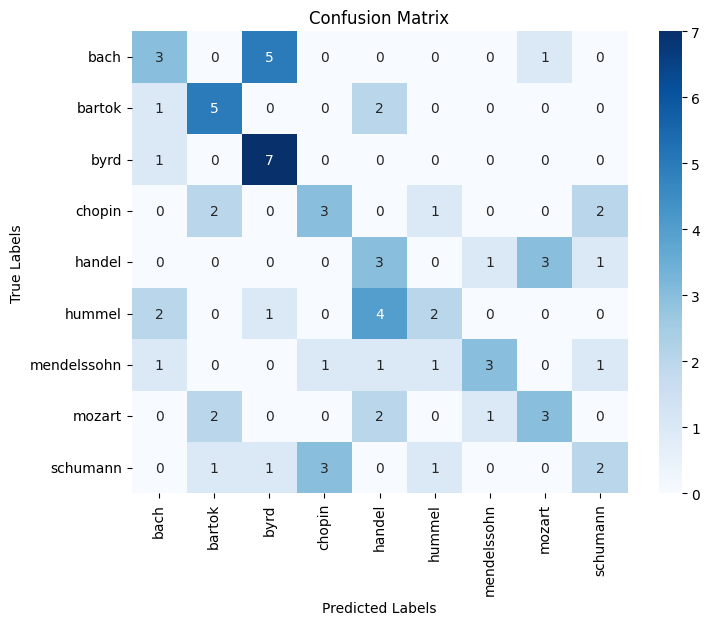

In [66]:
#@title 6.2: Print a confusion matrix V1
from sklearn.metrics import confusion_matrix
import seaborn as sns
#mport matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred_class)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [67]:
#@title 6.3: Report the confusion matrix V1
# Reshape the input data for prediction
X_test_scaled_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], num_steps, num_features)

# Make predictions on the reshaped test set
y_test_pred = model.predict(X_test_scaled_reshaped)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

# Convert predicted class labels back to original composer labels using the encoder
lstm_pred_labels = encoder.inverse_transform(y_test_pred_class)
lstm_true_labels = encoder.inverse_transform(np.argmax(y_test, axis=1))  # Convert true class labels back

# Print the classification report
lstm_classification_report_v1 = classification_report(lstm_true_labels, lstm_pred_labels, target_names=encoder.classes_)
print("Classification Report - LSTM Model ver 1:\n", lstm_classification_report_v1)

3/3 [==============================] - 0s 9ms/step
Classification Report - LSTM Model ver 1:
               precision    recall  f1-score   support

        bach       0.38      0.33      0.35         9
      bartok       0.50      0.62      0.56         8
        byrd       0.50      0.88      0.64         8
      chopin       0.43      0.38      0.40         8
      handel       0.25      0.38      0.30         8
      hummel       0.40      0.22      0.29         9
 mendelssohn       0.60      0.38      0.46         8
      mozart       0.43      0.38      0.40         8
    schumann       0.33      0.25      0.29         8

    accuracy                           0.42        74
   macro avg       0.42      0.42      0.41        74
weighted avg       0.42      0.42      0.41        74



Notes: Prediction from the LSTM model Ver. 1 shows good results with a 42% accuracy. some composer prediction do better than others.

#Version 2: LSTM with 3 Hidden Layers

In [68]:
#@title 7: LSTM Model Building V2
#from tensorflow.keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(patience=15)

num_classes = y_train.shape[1]
num_features = 5
model = Sequential([
    LSTM(128, activation='relu', input_shape=(num_steps, num_features), return_sequences=True),  # Note the return_sequences=True
    LSTM(64, activation='relu',return_sequences=True),  # Adding another LSTM layer
    LSTM(32, activation='relu'),  # Adding another LSTM layer
    Dense(num_classes, activation='softmax')
]) # 3 Hidden Layers

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 27, 128)           68608     
                                                                 
 lstm_15 (LSTM)              (None, 27, 64)            49408     
                                                                 
 lstm_16 (LSTM)              (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 9)                 297       
                                                                 
Total params: 130,729
Trainable params: 130,729
Non-trainable params: 0
_________________________________________________________________


In [69]:
#@title 7.1: LSTM Model Training V2
history2 = model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], num_steps, num_features),
                    y_train, epochs=100,
                    validation_data=(X_val_scaled.reshape(X_val_scaled.shape[0], num_steps, num_features), y_val)
)

Epoch 1/100
7/7 [==============================] - 8s 245ms/step - loss: 2.1796 - accuracy: 0.1448 - val_loss: 8.1361 - val_accuracy: 0.1892
Epoch 2/100
7/7 [==============================] - 1s 99ms/step - loss: 2.2080 - accuracy: 0.2036 - val_loss: 6.1377 - val_accuracy: 0.2297
Epoch 3/100
7/7 [==============================] - 1s 102ms/step - loss: 2.0260 - accuracy: 0.3077 - val_loss: 5.9858 - val_accuracy: 0.2703
Epoch 4/100
7/7 [==============================] - 1s 101ms/step - loss: 3.4427 - accuracy: 0.3394 - val_loss: 3.7851 - val_accuracy: 0.3108
Epoch 5/100
7/7 [==============================] - 1s 102ms/step - loss: 1.9123 - accuracy: 0.3756 - val_loss: 5.4624 - val_accuracy: 0.3108
Epoch 6/100
7/7 [==============================] - 1s 98ms/step - loss: 1.7635 - accuracy: 0.3801 - val_loss: 7.5251 - val_accuracy: 0.3649
Epoch 7/100
7/7 [==============================] - 1s 101ms/step - loss: 1.8105 - accuracy: 0.4389 - val_loss: 9.6032 - val_accuracy: 0.3649
Epoch 8/100
7/7

In [70]:
#@title 7.2: Evaluate the model V2
test_loss, test_accuracy = model.evaluate(X_test_scaled.reshape(X_test_scaled.shape[0], num_steps, num_features), y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

3/3 [==============================] - 0s 30ms/step - loss: 3.0773 - accuracy: 0.5000
Test Loss: 3.077254295349121
Test Accuracy: 0.5


Notes: Performance has increased with the added layer.
Test Loss: 3.077254295349121
Test Accuracy: 0.5

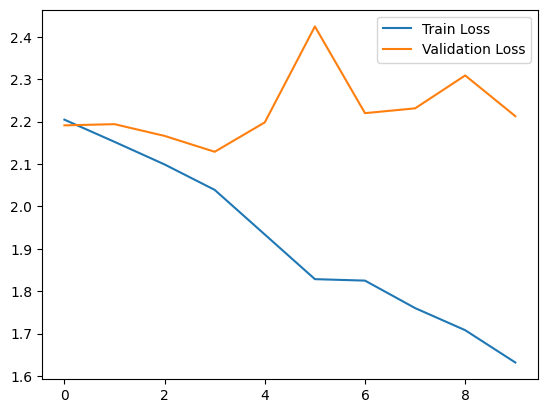

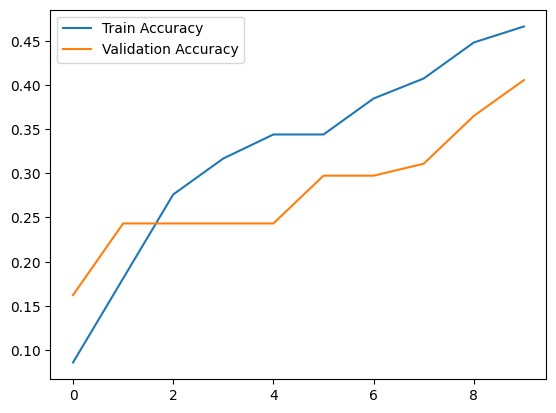

<function __main__.plot_learning_curves(history)>

In [71]:
#@title 8: Plot v2
plot_learning_curves(history2)

In [72]:
#@title 9: Save the model - And run predictions V2
model.save('team8_composer_model.h5') #file name

# Load the model
from tensorflow.keras.models import load_model
model = load_model('team8_composer_model.h5')

#@title 6v2: Make predictions on the scaled and reshaped test set
y_test_pred = model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], num_steps, num_features))

# Convert predicted probabilities to class labels
y_test_pred_class = np.argmax(y_test_pred, axis=1)

3/3 [==============================] - 1s 30ms/step


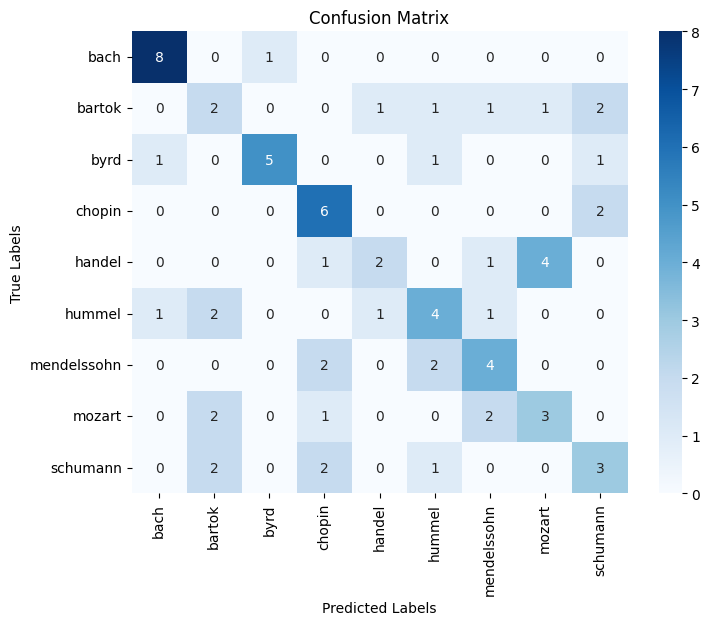

In [73]:
#@title 10.1: Plot the confusion matrix V2
# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred_class)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [74]:
#@title 10.2: Report the confusion matrix V2
# Reshape the input data for prediction
X_test_scaled_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], num_steps, num_features)

# Make predictions on the reshaped test set
y_test_pred = model.predict(X_test_scaled_reshaped)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

# Convert predicted class labels back to original composer labels using the encoder
lstm_pred_labels = encoder.inverse_transform(y_test_pred_class)
lstm_true_labels = encoder.inverse_transform(np.argmax(y_test, axis=1))  # Convert true class labels back

# Print the classification report
lstm_classification_report_v2 = classification_report(lstm_true_labels, lstm_pred_labels, target_names=encoder.classes_)
print("Classification Report - LSTM Model Version 2:\n", lstm_classification_report_v2)

3/3 [==============================] - 0s 28ms/step
Classification Report - LSTM Model Version 2:
               precision    recall  f1-score   support

        bach       0.80      0.89      0.84         9
      bartok       0.25      0.25      0.25         8
        byrd       0.83      0.62      0.71         8
      chopin       0.50      0.75      0.60         8
      handel       0.50      0.25      0.33         8
      hummel       0.44      0.44      0.44         9
 mendelssohn       0.44      0.50      0.47         8
      mozart       0.38      0.38      0.38         8
    schumann       0.38      0.38      0.38         8

    accuracy                           0.50        74
   macro avg       0.50      0.50      0.49        74
weighted avg       0.51      0.50      0.49        74



Notes: Performance has increased. The model has worked correctly with all composers, set at an S1 score of 50%

#Version 3 of LSTM, changing the Optimizer and doing an Eralystop

In [75]:
#@title 11: Updating more variables in the LSTM model and optimizer V3
from tensorflow.keras.optimizers import Adamax

#@title 7: LSTM Model Building
from tensorflow.keras.callbacks import EarlyStopping

# Adding an early stop to prevent overfitting
early_stopping = EarlyStopping(patience=15)

#define the optimizer
learning_rate = 0.01
optimizer = Adamax(learning_rate=learning_rate)

#Build the model
num_classes = y_train.shape[1]
num_features = 5
model = Sequential([
    LSTM(128, activation='relu', input_shape=(num_steps, num_features), return_sequences=True),  # Note the return_sequences=True
    LSTM(64, activation='relu',return_sequences=True),  # Adding another LSTM layer
    LSTM(32, activation='relu'),  # Adding another LSTM layer
    Dense(num_classes, activation='softmax')
]) # 3 Hidden Layers

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 27, 128)           68608     
                                                                 
 lstm_18 (LSTM)              (None, 27, 64)            49408     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 9)                 297       
                                                                 
Total params: 130,729
Trainable params: 130,729
Non-trainable params: 0
_________________________________________________________________


In [76]:
#@title 11.1: LSTM Model Training V3
history3 = model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], num_steps, num_features),
                    y_train, epochs=100,
                    validation_data=(X_val_scaled.reshape(X_val_scaled.shape[0], num_steps, num_features), y_val),
                    callbacks=[early_stopping])

Epoch 1/100
7/7 [==============================] - 8s 298ms/step - loss: 5.7065 - accuracy: 0.1403 - val_loss: 2.1193 - val_accuracy: 0.2568
Epoch 2/100
7/7 [==============================] - 1s 96ms/step - loss: 2.2823 - accuracy: 0.2579 - val_loss: 2.0364 - val_accuracy: 0.2432
Epoch 3/100
7/7 [==============================] - 1s 103ms/step - loss: 2.9281 - accuracy: 0.2851 - val_loss: 2.9626 - val_accuracy: 0.1622
Epoch 4/100
7/7 [==============================] - 1s 104ms/step - loss: 2.0920 - accuracy: 0.2534 - val_loss: 2.0342 - val_accuracy: 0.2432
Epoch 5/100
7/7 [==============================] - 1s 101ms/step - loss: 1.8689 - accuracy: 0.3394 - val_loss: 2.1388 - val_accuracy: 0.2838
Epoch 6/100
7/7 [==============================] - 1s 94ms/step - loss: 1.6934 - accuracy: 0.3394 - val_loss: 2.2628 - val_accuracy: 0.3108
Epoch 7/100
7/7 [==============================] - 1s 92ms/step - loss: 1.6872 - accuracy: 0.4027 - val_loss: 2.5447 - val_accuracy: 0.2703
Epoch 8/100
7/7 

In [79]:
#@title 11.2: Report the confusion matrix V3
# Reshape the input data for prediction
X_test_scaled_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], num_steps, num_features)

# Make predictions on the reshaped test set
y_test_pred = model.predict(X_test_scaled_reshaped)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

# Convert predicted class labels back to original composer labels using the encoder
lstm_pred_labels = encoder.inverse_transform(y_test_pred_class)
lstm_true_labels = encoder.inverse_transform(np.argmax(y_test, axis=1))  # Convert true class labels back

# Print the classification report
lstm_classification_report_v3 = classification_report(lstm_true_labels, lstm_pred_labels, target_names=encoder.classes_)
print("Classification Report - LSTM Model Version 3:\n", lstm_classification_report_v3)

3/3 [==============================] - 0s 30ms/step
Classification Report - LSTM Model Version 3:
               precision    recall  f1-score   support

        bach       0.73      0.89      0.80         9
      bartok       0.29      0.25      0.27         8
        byrd       0.86      0.75      0.80         8
      chopin       0.60      0.38      0.46         8
      handel       0.33      0.25      0.29         8
      hummel       0.50      0.11      0.18         9
 mendelssohn       0.13      0.25      0.17         8
      mozart       0.22      0.25      0.24         8
    schumann       0.33      0.50      0.40         8

    accuracy                           0.41        74
   macro avg       0.44      0.40      0.40        74
weighted avg       0.45      0.41      0.40        74



The best performance is of the Version 2 LSTM model, a 3 layer model utilizing the ReLU activation function and the Adam optimizer, with 100 ephocs.
See results:
Classification Report - LSTM Model Version 2:
               precision    recall  f1-score   support

        bach       0.80      0.89      0.84         9
      bartok       0.25      0.25      0.25         8
        byrd       0.83      0.62      0.71         8
      chopin       0.50      0.75      0.60         8
      handel       0.50      0.25      0.33         8
      hummel       0.44      0.44      0.44         9
 mendelssohn       0.44      0.50      0.47         8
      mozart       0.38      0.38      0.38         8
    schumann       0.38      0.38      0.38         8

    accuracy                           0.50        74
   macro avg       0.50      0.50      0.49        74
weighted avg       0.51      0.50      0.49        74

In [80]:
#@title 11.1: Check how we can improve for possible training set overfitting
# Small amounts of data may lead to overfitting of the model.
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Training set size: 221
Validation set size: 74
Test set size: 74


Notes: These small amounts of data explain why there is a huge difference between the training and validation accuracies and those of the test data as well. The small data size can lead to overfitting, where the model becomes too specialized for the training data and performs poorly on unseen data. Additionally, limited data may not capture the full complexity of the problem, resulting in suboptimal performance on both validation and test datasets. Let's try to optimize the LSTM model and see how it does, but note that optimizing hyperparameters when there is a small amount of data may not improve model performance. The best bet is to augment the data. However, the ideal metric for this project is not accuracy but categorical cross-entropy loss.

Next, let's optimize the model by adding L2 regularization to the LSTM layers to penalize large weights and reduce overfitting.

Notes: Increasing the model training time did reduce the losses, which is good, and it did increase the training accuracy. However, the difference between the validating accuracy and the training one is too much. Again, not having enough validation data is the cause of this overfitting.

Notes: So, we still did not achieve better validation and test accuracies even after reducing the number of units in the LSTM layers, adding L2 regularization, and increasing the dropout rate. Additionally, we increased the number of epochs to give the model more training time. Let's try early stopping. Not that we think it will improve the model's accuracy very much, but this time we will just decrease the number of epochs to 200 and set the stopping criteria to 10 to detect and stop the model's overfitting.

Notes: Clearly, introducing the early stopping criteria helped reduce overfitting and computational time. Notice how the scores are close enough to when we trained the same model earlier with 500 epochs but without early stopping.

Notes: The plot for the early stopping up to epoch 15, where the training was discontinued, showed a near-perfect trend for both the loss and accuracy metrics. Beyond this epoch and based on our patience/stopping criteria of 10, the model will start to show signs of overfitting. The loss metric will begin to increase slightly, while the accuracy metric will start to plateau. This indicates that the model had learned all it could from the training data and that further training would not lead to better performance.

# CNN Model V1

In [81]:
#@title 16: Build CNN Model
#Load related libraries
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define the number of classes (number of composers)
num_classes = len(encoder.classes_)

# Build the CNN model
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(num_steps, X_train.shape[2])),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 64)            1024      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [82]:
#@title 16.1: CNN Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/50
7/7 [==============================] - 2s 58ms/step - loss: 12.0866 - accuracy: 0.1403 - val_loss: 5.4812 - val_accuracy: 0.2568
Epoch 2/50
7/7 [==============================] - 0s 14ms/step - loss: 4.8394 - accuracy: 0.2715 - val_loss: 3.6626 - val_accuracy: 0.2568
Epoch 3/50
7/7 [==============================] - 0s 15ms/step - loss: 2.9806 - accuracy: 0.2851 - val_loss: 2.8137 - val_accuracy: 0.2703
Epoch 4/50
7/7 [==============================] - 0s 15ms/step - loss: 1.8298 - accuracy: 0.4118 - val_loss: 2.4100 - val_accuracy: 0.2703
Epoch 5/50
7/7 [==============================] - 0s 14ms/step - loss: 1.5586 - accuracy: 0.4661 - val_loss: 2.2878 - val_accuracy: 0.2973
Epoch 6/50
7/7 [==============================] - 0s 13ms/step - loss: 1.4629 - accuracy: 0.4977 - val_loss: 2.2467 - val_accuracy: 0.2973
Epoch 7/50
7/7 [==============================] - 0s 14ms/step - loss: 1.3634 - accuracy: 0.4751 - val_loss: 2.2397 - val_accuracy: 0.3378
Epoch 8/50
7/7 [==========

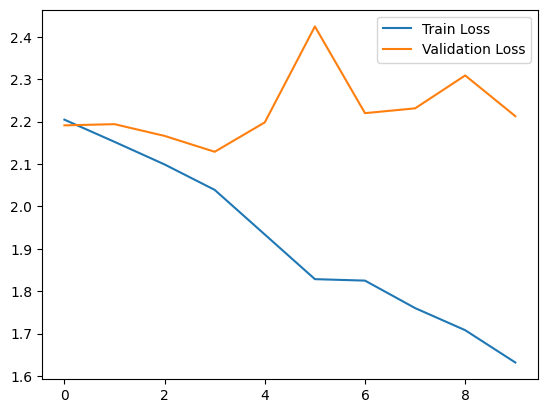

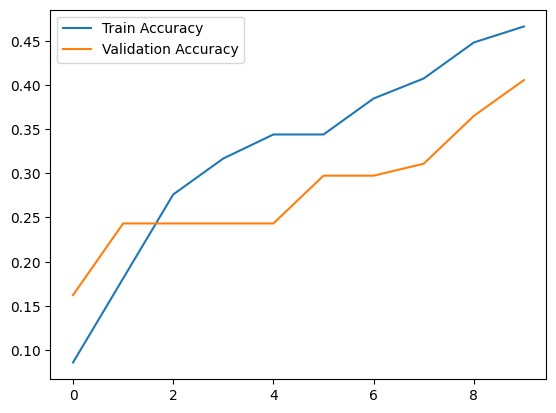

<function __main__.plot_learning_curves(history)>

In [83]:
#@title 16.2: Plot history
plot_learning_curves(history)

Notes: As with the LSTM model that we built earlier, this CNN model's accuracy metric is not so good on the validation data, and the reason is that we do not have sufficient validation or test data for the model to generalize well on them, further contributing to the difference in accuracy between the training and validation sets.

Assuming we are focusing more on optimizing the model loss, we will make a graph of the loss alone.

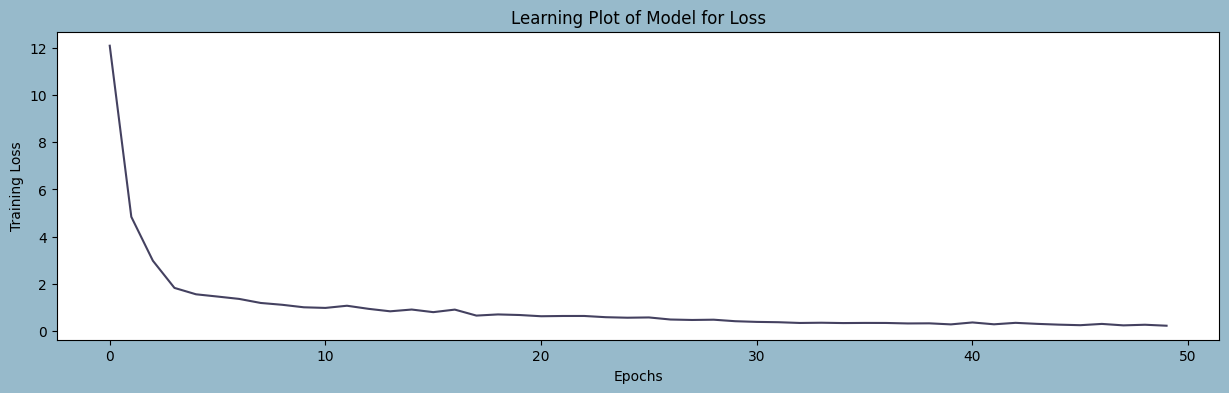

In [84]:
#@title 16.3: Plot of Loss
history_df = pd.DataFrame(history.history)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 4), facecolor="#97BACB")

# Plotting the learning curve for loss
ax.plot(history_df["loss"], color="#444160")

# Set title and labels
ax.set_title("Learning Plot of Model for Loss")
ax.set_ylabel("Training Loss")
ax.set_xlabel("Epochs")

# Show the plot
plt.show()

Notes: This graph clearly shows how the model improved as the training progressed and losses continued to decrease to the terminal epoch.

3/3 [==============================] - 0s 4ms/step


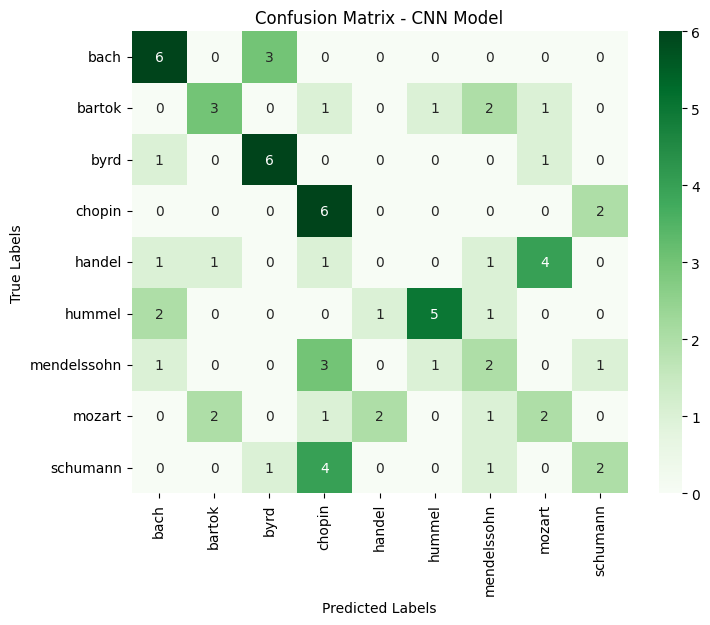

Classification Report - CNN Model:
               precision    recall  f1-score   support

        bach       0.55      0.67      0.60         9
      bartok       0.50      0.38      0.43         8
        byrd       0.60      0.75      0.67         8
      chopin       0.38      0.75      0.50         8
      handel       0.00      0.00      0.00         8
      hummel       0.71      0.56      0.63         9
 mendelssohn       0.25      0.25      0.25         8
      mozart       0.25      0.25      0.25         8
    schumann       0.40      0.25      0.31         8

    accuracy                           0.43        74
   macro avg       0.40      0.43      0.40        74
weighted avg       0.41      0.43      0.41        74



In [85]:
#@title 16.4: Store the CNN model predictions in 'cnn_predictions' and plot matrix
cnn_predictions = model.predict(X_test)

# Convert the one-hot encoded predictions and true labels back to class indices
cnn_pred_labels = np.argmax(cnn_predictions, axis=1)
cnn_true_labels = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cnn_cm = confusion_matrix(cnn_true_labels, cnn_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Greens', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN Model')
plt.show()

# Print the classification report
cnn_classification_report = classification_report(cnn_true_labels, cnn_pred_labels, target_names=encoder.classes_)
print("Classification Report - CNN Model:\n", cnn_classification_report)

Notes: We noticed that the test loss, validation loss, test accuracy, and validation accuracy parameters are almost identical. This could be because of the size of their data sets. To address the difference in training and validation accuracies, we can try augmenting the data by applying small, random transformations to the input data. This will might help improve the accuracy of the model.

# 17: CNN V2: Convert MIDI data to Spectrum visuals
## Converting Midi Files to Wav files
- Using fluidsynth and sound font files to convert midi files to wav files
- Created a shell script to iterate through the directories


````
#!/bin/bash

# Set the location of your soundfont file
sound_font="../TimGM6mb.sf2"

# Iterate over all directories in the current directory
for dir in */
do
  # Go inside each directory
  cd "$dir"

  # Iterate over all .mid files in the current directory
  for midi_file in *.mid
  do
    # Replace the file extension from .mid to .wav
    wav_file="${midi_file%.mid}.wav"

    # Use fluidsynth to convert the midi file to a wav file
    /mnt/host/c/tools/fluidsynth-2.3.2-win10-x64/bin/fluidsynth.exe -ni "$sound_font" "$midi_file" -F "$wav_file" -r 44100
  done

  # Go back to the parent directory
  cd ..
done

````

In [86]:
#@title 17.1: Load related libraries
### Sample of wav file and spectrograph
import librosa
audio_data = "train/bach/bach346.wav"
librosa.load(audio_data)
import matplotlib.pyplot as plt
x , sr = librosa.load(audio_data)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

SystemError: ignored

## 17.2: Code to generate png files from wav files
- code run once as wav files generated were very large and not stored in CM (github)
- once the png files were generated they were stored as png files in CM (github)

In [ ]:
from PIL import Image
import numpy as np
import os
from skimage import transform
import librosa
import matplotlib.pyplot as plt
from scipy import ndimage
import matplotlib.pyplot as plt

import re

def change_extension(filename, new_extension):
    return re.sub(r'\.\w+$', new_extension, filename)

def generate_images(dataset_path):
    X = []
    y = []
    composers = os.listdir(dataset_path)
    for i, composer in enumerate(composers):
        composer_path = os.path.join(dataset_path, composer)
         # Check if it is a directory
        if os.path.isdir(composer_path):
            for filename in os.listdir(composer_path):
                if filename.endswith('.wav'):
                    print(dataset_path + "/" + composer + "/" + filename)
                    %matplotlib inline
                    x , sr = librosa.load(dataset_path + "/" + composer + "/" + filename)
                    X = librosa.stft(x)
                    img_filename = change_extension(filename, ".png")

                    # Generate spectrogram
                    D = np.abs(X)
                    # Resize to 224x224
                    D_resized = ndimage.zoom(D, (224.0/D.shape[0], 224.0/D.shape[1]))

                    # Generate the image
                    plt.figure(figsize=(5, 5))
                    librosa.display.specshow(librosa.amplitude_to_db(D_resized, ref=np.max), sr=sr, x_axis='time', y_axis='log')
                    plt.tight_layout()
                    plt.savefig(dataset_path + "/" + composer + "/" + img_filename)
                    print(img_filename)
                    plt.close()


### 17.3: Read image files to generate numpy array to train CNN

In [ ]:
# Not used as the png files were already generated
# generate_images('train')

In [ ]:
def load_image(filename):
    img = Image.open(filename)
    img = img.convert('RGB')  # Convert image to RGB if it's not
    return np.array(img)

def load_dataset(dataset_path):
    composers = os.listdir(dataset_path)
    img_count = sum([len(files) for r, d, files in os.walk(dataset_path) if files])

    X = np.zeros((img_count, 500, 500, 3), dtype=np.uint8)
    y = np.zeros(img_count, dtype=np.int)

    index = 0
    for i, composer in enumerate(composers):
        composer_path = os.path.join(dataset_path, composer)
        # Check if it is a directory
        if os.path.isdir(composer_path):
            print(f'Processing {composer_path}')
            for filename in os.listdir(composer_path):
                if filename.endswith('.png'):
                    # Load the image
                    img_array = load_image(os.path.join(composer_path, filename))

                    # Check if the image has the expected shape
                    if img_array.shape != (500, 500, 3):
                        print(f"Skipping {filename} due to shape mismatch. Expected (500, 500, 3), got {img_array.shape}.")
                        continue

                    # Append the image to the dataset
                    X[index] = img_array
                    # Append the composer's index to the labels
                    y[index] = i
                    index += 1

    y = np.array(y)
    print(y.shape)
    print(X.shape)
    return X[:index], y[:index] # Return only the part of the arrays that was filled




In [ ]:
# Load the dataset
X, y = load_dataset('train')

C:\Users\chris\AppData\Local\Temp\ipykernel_27616\1515538692.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros(img_count, dtype=np.int)


Processing train\bach
Skipping bach343.png due to shape mismatch. Expected (500, 500, 3), got (500, 1400, 3).
Processing train\bartok
Processing train\byrd
Processing train\chopin
Processing train\handel
Processing train\hummel
Processing train\mendelssohn
Processing train\mozart
Processing train\schumann
(752,)
(752, 500, 500, 3)


## 17.4: Create CNN-2 to check if using spectrographs will provide a better model

In [ ]:
#Load related libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

number_of_classes = 11  # Assuming you have 10 classes

X = X/255.0

# Split the dataset into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Create a CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(number_of_classes)  # Output layer without activation, since we're using from_logits=True
])

# Compile the model with sparse categorical cross-entropy loss
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
10/10 [==============================] - 45s 3s/step - loss: 22.2864 - accuracy: 0.1190 - val_loss: 2.4631 - val_accuracy: 0.1216
Epoch 2/10
10/10 [==============================] - 32s 3s/step - loss: 2.1911 - accuracy: 0.1531 - val_loss: 2.4841 - val_accuracy: 0.0811
Epoch 3/10
10/10 [==============================] - 31s 3s/step - loss: 1.9691 - accuracy: 0.2517 - val_loss: 1.7227 - val_accuracy: 0.3514
Epoch 4/10
10/10 [==============================] - 31s 3s/step - loss: 1.5068 - accuracy: 0.4830 - val_loss: 1.7567 - val_accuracy: 0.2568
Epoch 5/10
10/10 [==============================] - 31s 3s/step - loss: 1.4346 - accuracy: 0.4728 - val_loss: 1.4142 - val_accuracy: 0.4459
Epoch 6/10
10/10 [==============================] - 31s 3s/step - loss: 0.8556 - accuracy: 0.7109 - val_loss: 1.1984 - val_accuracy: 0.5676
Epoch 7/10
10/10 [==============================] - 30s 3s/step - loss: 0.6289 - accuracy: 0.8129 - val_loss: 1.2843 - val_accuracy: 0.5135
Epoch 8/10
10/10 [=

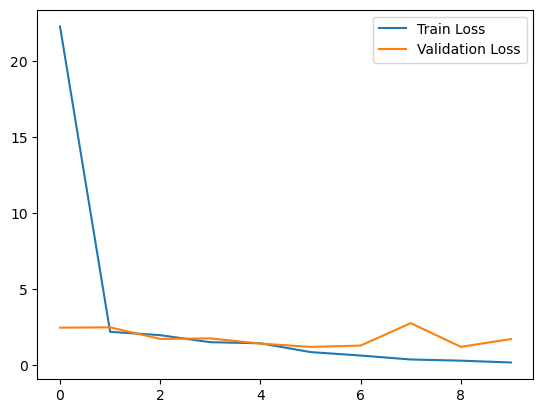

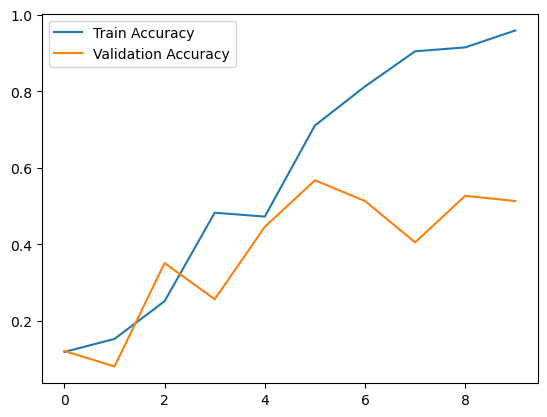

<function __main__.plot_learning_curves(history)>

In [ ]:
#@title 17.5: Plot the training and validation loss
def plot_learning_curves(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.show()
    return plot_learning_curves


plot_learning_curves(history)